In [6]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%load_ext line_profiler
%load_ext memory_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [8]:
module = fc.eightb.training.training_5M

In [9]:
signal = ObjIter([ Tree(f, altfile='fully_res_{base}') for f in module.full_signal_list])

100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


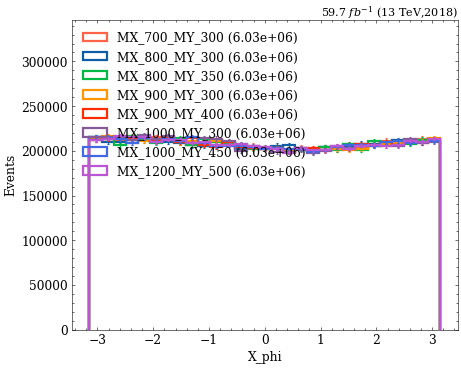

In [12]:
study.quick( 
    signal,
    legend=True,
    scale=lambda t:t.dataset_norm_abs_scale/t.scale,
    varlist=['X_phi']
)

In [13]:
training_sig = '/eos/uscms/store/user/ekoenig/8BAnalysis/NTuples/2018/training/sig/split_*_training_sig.root'
# training_sig = '/eos/uscms/store/user/ekoenig/8BAnalysis/NTuples/2018/training/training_5M/*{MX_700_MY_300}'
training_bkg = '/eos/uscms/store/user/ekoenig/8BAnalysis/NTuples/2018/training/bkg/split_*_training_bkg.root'

In [14]:
sig = ObjIter([Tree(training_sig)])
bkg = ObjIter([Tree(training_bkg)])

100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


In [15]:
for t in sig: t.is_signal = True

In [16]:
bkg.dataset_norm_abs_scale

[<Array [0.00337, 0.00337, ... 0.000316] type='548604 * float64'>]

100%|██████████| 1/1 [00:04<00:00,  4.51s/it]


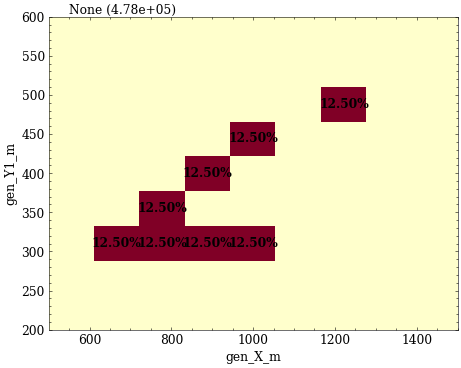

In [17]:
study.quick2d( 
    sig,
    legend=True,
    h_color=['green','lightblue'],
    scale=lambda t:t.abs_scale/t.scale,
    varlist=['gen_X_m','gen_Y1_m'],
    binlist=[(500,1500,10),(200,600,10)],
    efficiency=True,
    show_counts=lambda n:f'{n:0.2%}' if n > 0 else None,
)

100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


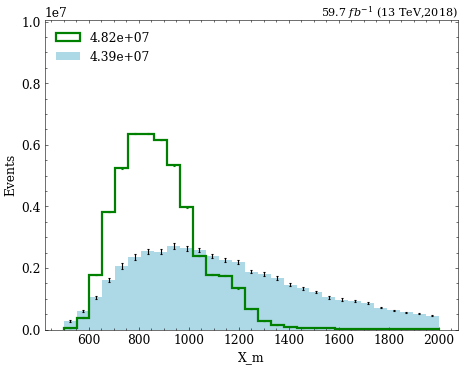

In [18]:
study.quick( 
    sig+bkg,
    legend=True,
    h_color=['green','lightblue'],
    scale=lambda t:t.dataset_norm_abs_scale/t.scale,
    varlist=['X_m']
)

In [46]:
is_bkg = (sig+bkg).is_bkg.cat.to_numpy()
weight = (sig+bkg).dataset_norm_abs_scale.cat.to_numpy()
x_m = (sig+bkg).X_m.cat.to_numpy()

In [47]:
def resample(weight, n=10):
    index = np.arange(len(weight))
    sample = [ index[weight > np.random.uniform(size=len(weight))] for _ in range(n) ]
    return np.concatenate(sample)


In [48]:
sample = resample(weight, n=10)

In [49]:
r_is_bkg = is_bkg[sample]
r_x_m = x_m[sample]

(<Figure size 650x650 with 2 Axes>,
 <AxesSubplot:ylabel='PDF'>,
 [HistoList<[<utils.plotUtils.histogram.Histo object at 0x7fde98457610>, <utils.plotUtils.histogram.Histo object at 0x7fde7c90fa00>]>])

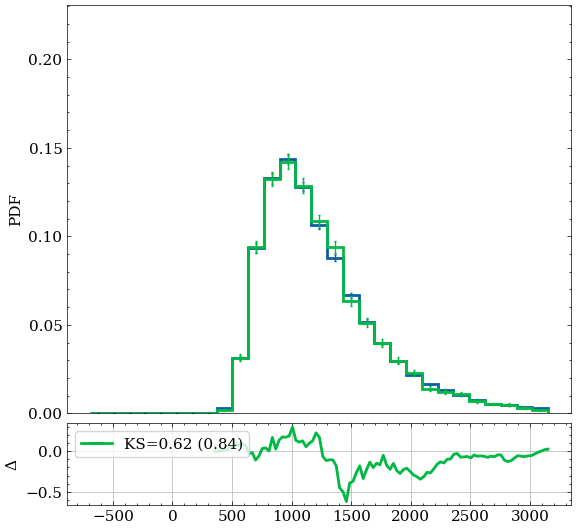

In [50]:
hist_multi([ x_m[is_bkg==1], r_x_m[r_is_bkg==1] ], weights=[weight[is_bkg==1]], efficiency=True, **study.kstest)

(<Figure size 650x650 with 2 Axes>,
 <AxesSubplot:ylabel='PDF'>,
 [HistoList<[<utils.plotUtils.histogram.Histo object at 0x7fde0440d880>, <utils.plotUtils.histogram.Histo object at 0x7fde29a9c7c0>]>])

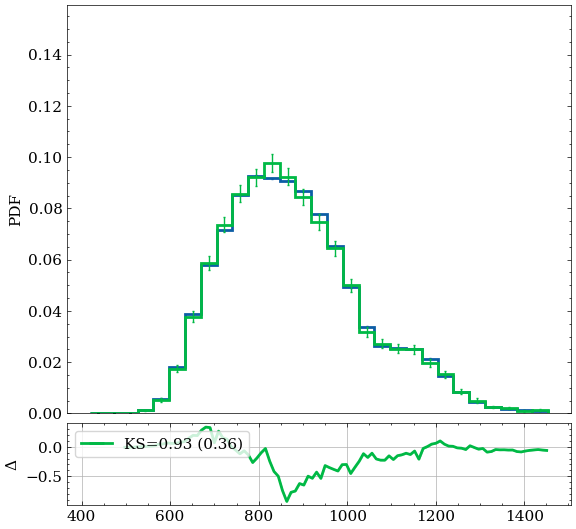

In [51]:
hist_multi([ x_m[is_bkg==0], r_x_m[r_is_bkg==0] ], weights=[weight[is_bkg==0]], efficiency=True, **study.kstest)